# Running a program in Linux AArch64
***

## 1. C Program (or other high-level language)

In [1]:
%%file run.c

// Example of a standard Hello World program --> THIS IS RUN IN USER MODE
#include <stdio.h>
int main() {
    printf("Hello world");
    return 0;
}

// or lower level code (this is a lower level program that works in Linux)
void _start(void) {
    write(1, "Hello world\n", 12);
    exit_group(0);
}


Overwriting run.c


***
## 2. System Calls (C program compiled into)

> System Calls is how a program (that runs in user mode) <mark>Make Requests to the Operating System</mark>

We can represent system calls like regular C functions. For example: Here are two system calls we need for a basic “Hello world” program:

> <span style="color:red">ssize_t</span> <span style="color:cyan">write</span>(int fd, const void *buf, size_t count);
> 
> Description: writes bytes from a byte array to a file descriptor
> 
>   - fd - the file descriptor
>
>   - buf - the address of the start of the byte array (called a buffer)
>
>   - count - how many bytes to write from the buffer

> <span style="color:red">void</span> <span style="color:cyan">exit_group</span>(int status);
> 
> Description: exits the current process and sets an exit status code
>
>   - status - the exit status code (0-255)

By convention there’s some expected file descriptors:
- 0 - standard input (read)
- 1 - standard output (write)
- 2 - standard error (write)

> #### Definition: File Descriptor
>
> Since our processes are independent, we need an explicit way to transfer data
>
> **IPC**: inter-process communication is transferring data between two processes
>
> **File descriptor**: a resource that users may either read bytes from or write bytes to (identified by an index stored in a process)
>
> --> A file descriptor is a identification of a file, or your terminal (things to transfer data) during the execution of a process

***
## 3. Assembly and ELF

> #### Definition: API and ABI
>
> - Application Programming Interface (API) abstracts the details and describes the arguments and return value of a function
>
>   *e.g. A function takes 2 integer arguments and returns a double*
>
> - Application Binary Interface (ABI) specifies the details, specifically how to pass arguments and where the return value is
>       
>   *e.g. A C function pass arguments through a stack (or in Assembly, pass arguments to subroutines to registers, etc.)*
        

### System Call ABI for Linux AArch64

The operating system “functions” do not have an address, instead we can generate an interrupt for the OS

Generate an interrupt with a **svc** instruction, using registers for arguments (passing arguments, then svc):
- x8 — System call number
- x0 — 1st argument
- x1 — 2nd argument
- x2 — 3rd argument
- x3 — 4th argument
- x4 — 5th argument
- x5 — 6th argument

### Programs on Linux Use the ELF File Format

Executable and Linkable Format (ELF) specifies both executables and libraries

**Always starts with the 4 bytes**: 0x7F 0x45 0x4C 0x46 or with ASCII encoding: DEL 'E' 'L' 'F'

These 4 bytes are called “magic”, and that’s how you know what kind of file this is. Other file formats may have a different number of bytes
        
*e.g. PDF files start with %PDF-*


### Our Bytes Represent an ELF File (for this specific example)

- Tells the OS to load the entire executable file into memory at address 0x10000.
- The file header is 64 bytes, and the “program header” is 56 bytes (120 bytes total)
- The next 36 bytes are instructions, then 12 bytes for the string "Hello world\n".
- Instructions start at 0x10078 (0x78 is 120).
- The string (data) starts at 0x1009C (0x9C is 156)

You can use: readelf -a <FILE> to see the gory details

### How ELF file gets divided

![Screenshot 2023-09-08 at 2.33.08 PM.png](<attachment:Screenshot 2023-09-08 at 2.33.08 PM.png>)
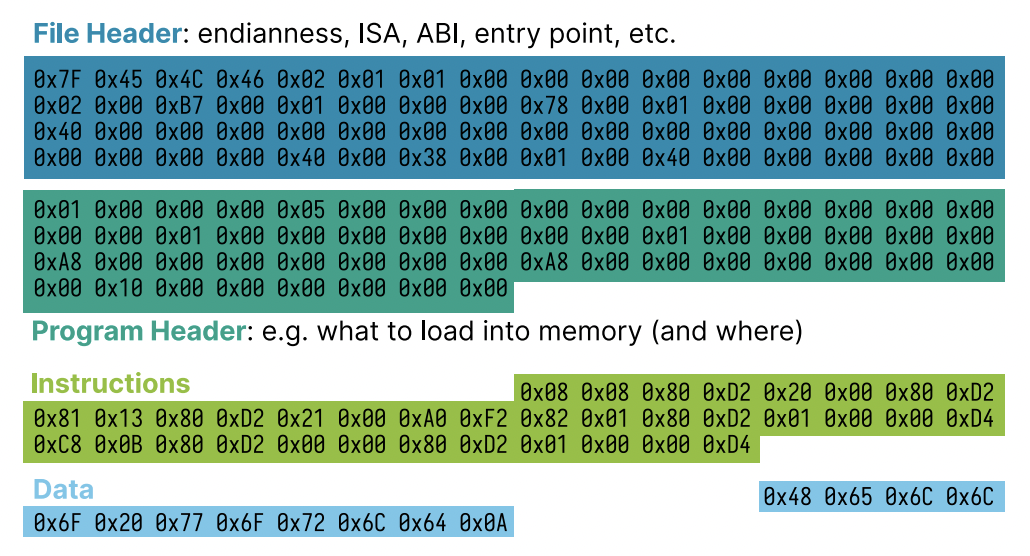

***
## 4. Assembly instructions are disassembled into Machine code

The disassembly process is based on which **Instruction Set Architechtures (ISA)** the instructions follow (specified in the file header)

There are 3 main ISAs today

- x86-64 (aka amd64): for desktops, non-Apple laptops, servers
- aarch64 (aka arm64): for phones, tablets, Apple laptops
- riscv (aka rv64gc): open-source implementation, similar to ARM

> Disembled instructions: (Notice that parameters are passed in through registers, then **svc** calls are made to actually make system calls)

![Alt text](images/image.png)

Recall: There is a specific "way" that Assembly can be converted to Machine Code

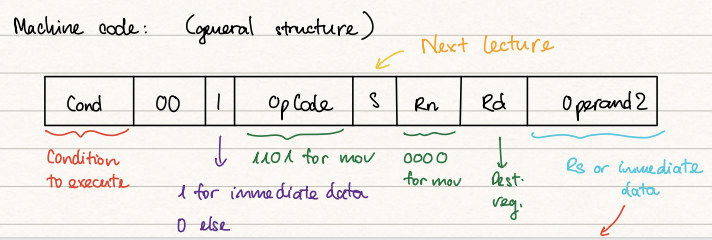

***
# Kernel

### Kernel is a core part of your OS

There is almost always a <mark>Kernel mode</mark> in each OS, which is a privilege level on your CPU that can directly manipulate the hardware

> The kernel is the part of your operating system that runs in kernel mode (separate CPU mode than user mode)
>      
> When you run a program, the program makes **system calls** (or switch mode) to the kernel mode, which actually performs the task
>
> If a program running in kernel mode fails, the entire system will crash (hold). If user program fails, the OS can manage it and it's safe

*e.g., only the kernel can manage virtual memory for processes*

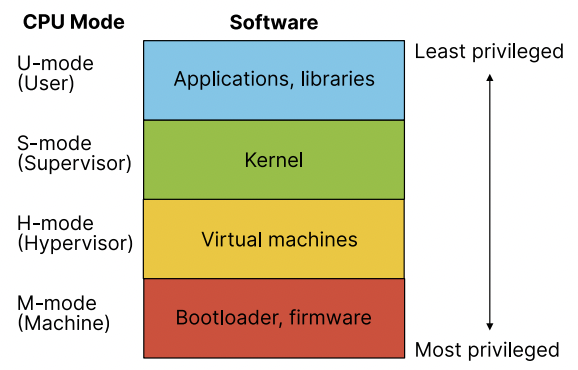

(U-mode: ECE244, This course: S-mode (and boundary with U-mode) and H-mode (end of course), M-mode: ECE243)

### System Calls Transition between user mode and kernel mode

There are 453 system call commands in total in Linux aarch64:

    read write open close stat mmap brk pipe clone fork  
    execve exit wait4 chdir mkdir rmdir creat mount  
    init_module delete_module clock_nanosleep exit_group

### System Calls are tracable 

We can trace all system calls a process makes on Linux using command: 

    strace <PROGRAM>

For example, all the system calls our "Hello world" program (the short version, specificly for aarch64 linux) makes:

In [12]:
%%file run.c

execve("./hello_world", ["./hello_world"], 0x7ffd0489de40 /* 46 vars */) = 0
write(1, "Hello world\n", 12)           = 12
exit_group(0)                           = ?
+++ exited with 0 +++

Overwriting run.c


### The Kernel is a "Long Running Program"

Writing kernel code (what we did in Lab 0 - interacting with the kernel through the Terminal) does not need a main

The kernel lets you load code into it (called <mark>kernel modules</mark>)

Your code executes on-demand *e.g. when it’s loaded manually, new hardware, or accessing a certain file*

If you write a kernel module, you can execute privileged instructions and access any kernel data, so you could do anything

***

# Types of Kernel Architechture

> Different types will decide how much code is actually run in kernel mode (the rest will be handled in user mode - less access)

###  Monolithic Kernel - Linux

"Put everything into the Kernel mode"  
--> Reduce the number of system calls you have to make (to transition between user mode and kernel mode), and allow calls do a lot, interact directly with the hardware  
--> Make things fast

A Monolithic Kernel Runs Operating System Services in Kernel Mode

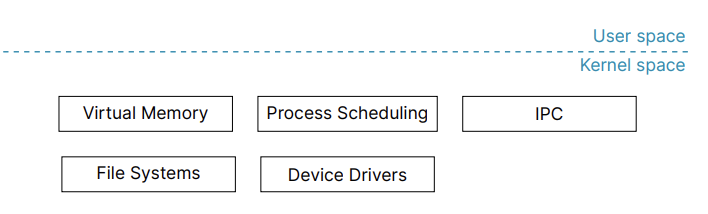

This means we are exploiting kernel mode, having control over everything --> security problems

### Microkernel 

Reduce things that is in the kernel (only minimal things are still kept)

A Microkernel Runs the Minimum Amount of Services in Kernel Mode

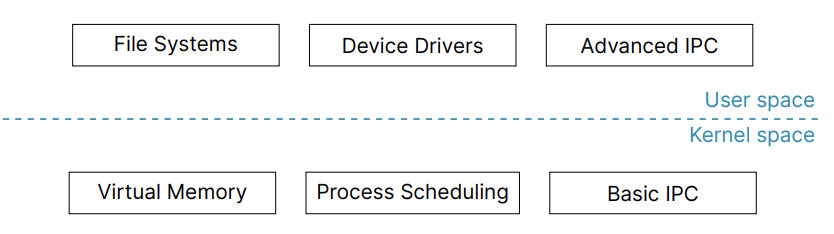

### Other Types of Kernels

- Hybrid kernel; (Windows): Emulation services to user mode
(macOS): Device drivers to user mode

- Nanokernels and picokernels

## OVERVIEW:

- The kernel is the part of the OS that interacts with hardware (it runs in kernel mode)
- System calls are the interface between user and kernel mode
- File format and instructions to define a simple “Hello world” (in 168 bytes) (will not be tested)
- Different kernel architectures shift how much code runs in kernel mode
